# Summary

- 39.9d period works better than established period of 40.03
    - don't know where that value is from, but 39.9 days within uncertainty from Bartlett
    - shown to be better in periodograms, phase-folded/step, and by inspection on LC (with subplots and spaced lines)
- no pattern in superorbital flaring; would need longer monitoring to see if spacings repeat or obey another trend
- V-I clusters from different parts of LC
- opposite correlations in I vs. V-I and V vs. V-I (though some parts still look the same in V vs. V-I)
    - b/c V gets brighter after I flares (when I gets fainter)
    - **to do** plot interpolated points with same colorbar on I band LC
    - V-I vs time helpful: wider flares in V-I than I

# Outline
- 1: Sequence of Three Auto Functions that Inform Further Search
- 2: Look for Orbital Period with Periodograms
- 3: Look for Orbital Period with LC
- 4: Look for Super-Orbital Period with Periodograms
- 5: Look for Super-Orbital Period with LC

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
#change src number here
num = 10
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
orb = float(cross[cross['src_n']==num]['Porb'])
orb

40.03

In [3]:
full[full['src_n']==num]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
10,SMC719.18 \#465,00:57:58.51,-72:22:29.2,14.493333,-72.37486,1.5,7.92,40.03,14.494166666666665,-72.37463888888888,41895,15.2,1.2145301423329555,14.494034999999997,-72.37459999999999,15.717,3156828,1.216538372448185


- spin period: 7.92

# 1: Sequence of Three Auto Functions that Inform Further Search

orbital period: 40.03


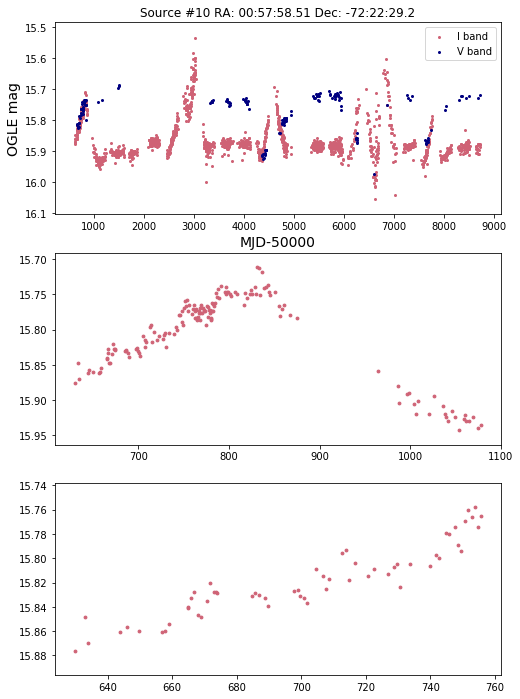

In [4]:
ilist,vlist = o.getIV(num,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

In [5]:
idays = iband['MJD-50000']
imag = iband['I mag']
ierr = iband['I mag err']

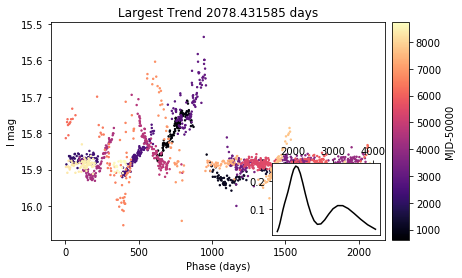

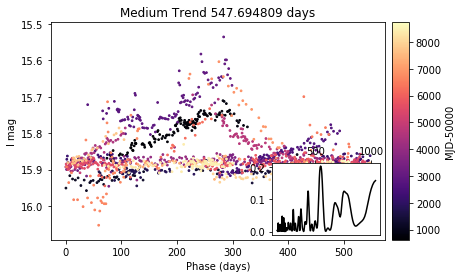

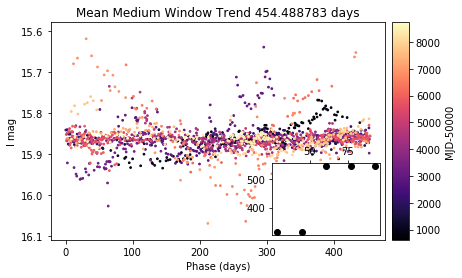

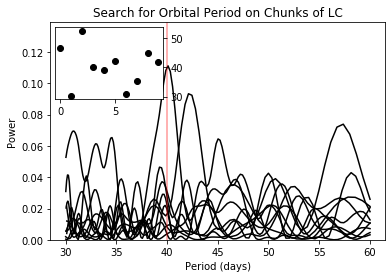

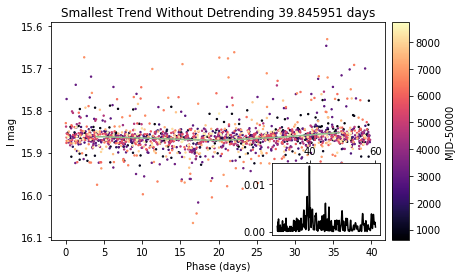

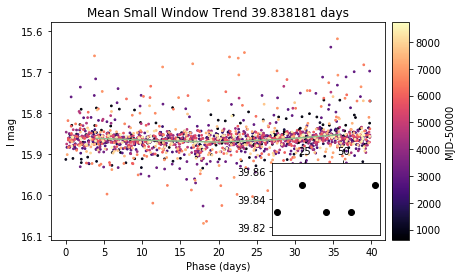

In [6]:
o.autopd(iband,orb,plotpd=True,plotphase=True,printall=False,ctime=True,orb_bounds=(10,20),cutlc=True,numcuts=10,plotdet=True,pbins=5,saveall=False,srcnum=num)

autopd getting less than orbital period, 39.8 days

I and V-I correlation: -0.6832617411444406
V and V-I correlation: 0.7737722449334529


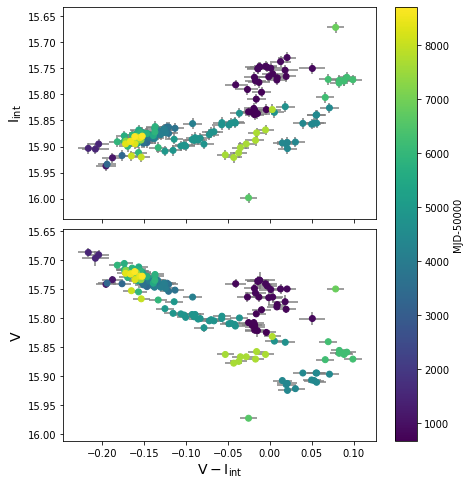

In [7]:
reload(o)
interp = o.colormag(iband,vband,ctime=True,retint=True) 

(16.083000000000002, 15.506)

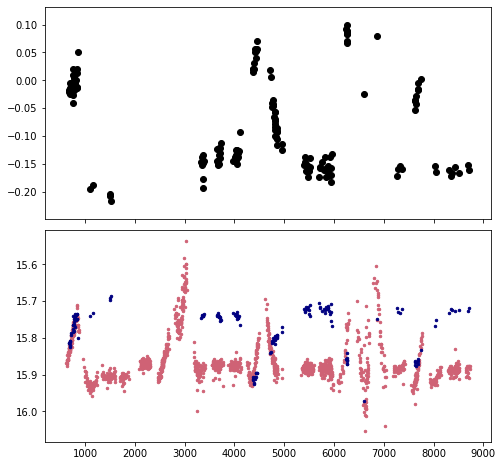

In [8]:
#V-I vs time over I mag lc
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
ax[0].scatter(vband['MJD-50000'],vband['V mag']-interp,color='black')
# plt.colorbar(label=('I mag'))
ax[1].scatter(idays,imag,color=pink,s=6)
ax[1].scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=6)

plt.subplots_adjust(hspace=0.05)
maxi,mini = np.max(imag),np.min(imag)
ax[1].set_ylim(maxi+.03,mini-.03)

# 2: Look for Orbital Period with Periodograms

first search for low periods and look for possible aliases

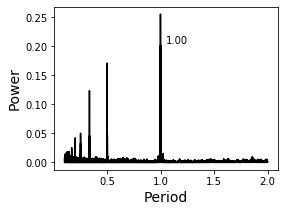

In [9]:
freq,power,bp = o.periodogram(iband,minp=0.1,maxp=2,more=True)
pf = o.findpeaks(freq,power,pkorder=True)

In [10]:
#find aliases using top ten periods above
alias = o.aliasarr(pf['period'],nrange=4)
alias[alias>2]

array([  167.79285419,   200.18455919,   167.50443885,   313.06455765,
         272.08208834,   136.94209239,   220.31616015,   154.71590022,
         128.88565693,   530.0717157 ,   310.86526102,   445.98517763,
         219.22468582,   199.28303245,   270.41938227,  1099.06852803,
         563.87850351,   166.18851782,   377.45268293,  2267.23404648,
         184.32838623,   439.14308871,  1058.42899244,  2156.732017  ,
         556.78354848,   308.69664919,  1867.03101398,   218.73262183,
         701.29742586,   542.5047254 ,   268.77687451,   370.8359016 ,
       22616.23051815])

can come back to aliases above when looking for superorbital

by OGLE epoch then dense regions 

In [11]:
len(ilist)

3

In [12]:
orb

40.03

start ind: 0, end ind: -1
start ind: 0, end ind: -1
start ind: 0, end ind: -1


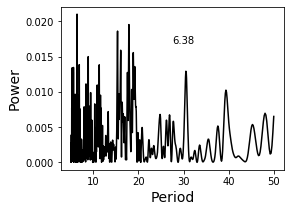

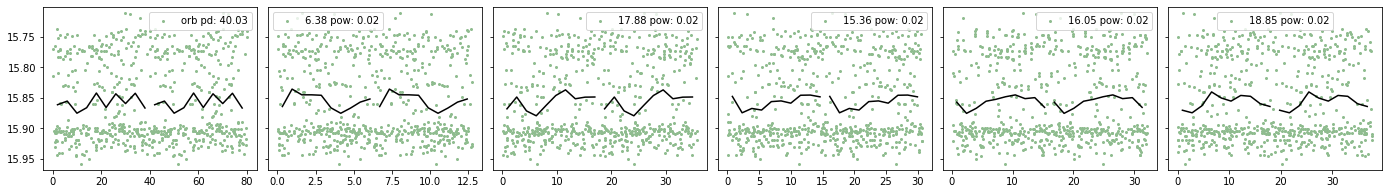

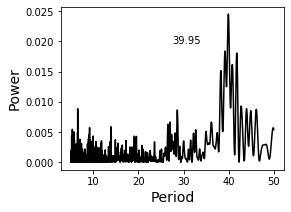

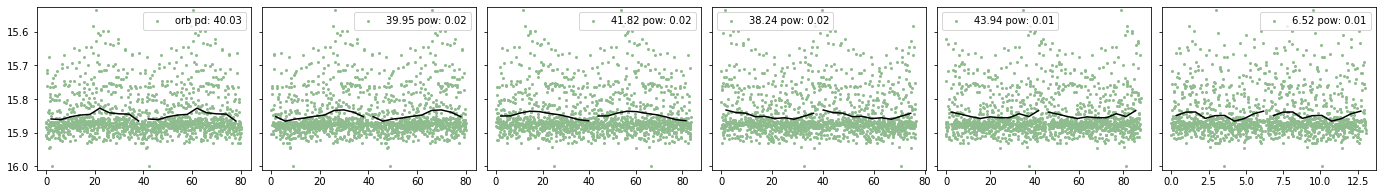

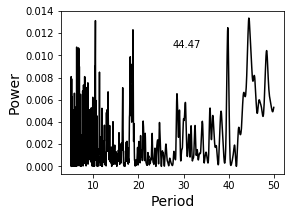

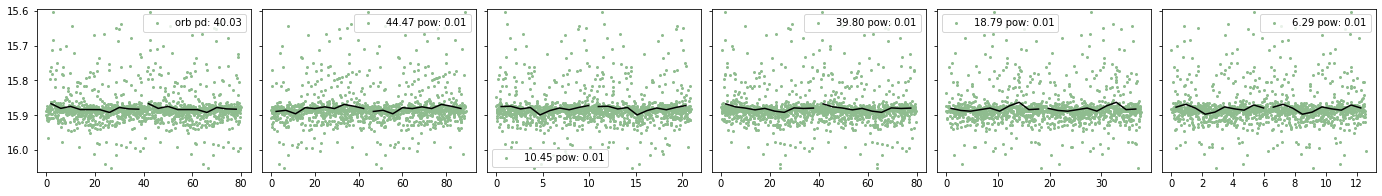

In [13]:
#without detrending
#always get high peak at exactly one day b/c of observing
for i in ilist:
    df,pks = o.multiphase(i,orb=orb,dense=False,minp=5,maxp=50,plotpd=True)

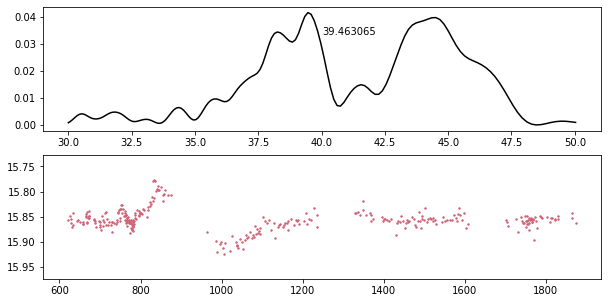

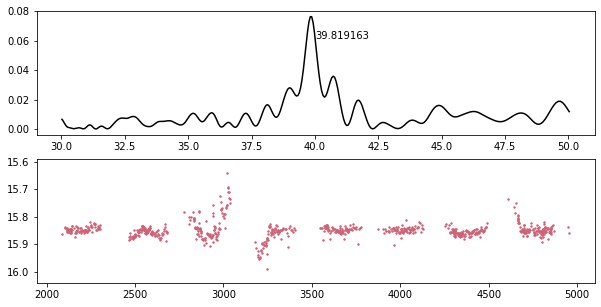

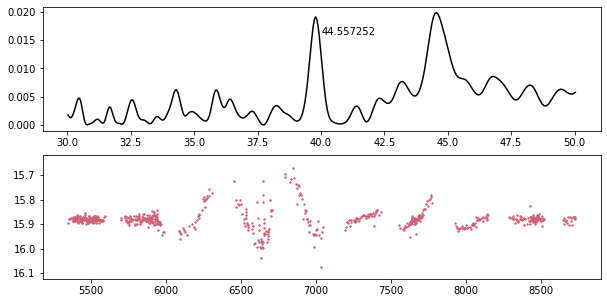

In [14]:
#detrending each OGLE epoch
#varies just a bit based on window
for i in ilist:
    o.knownorb(i,orb,lower=10,upper=10,window=61,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))


again, getting ~39 rather than orb
- tried a few windows

**separate into regions**

start ind: 1039, end ind: 1182


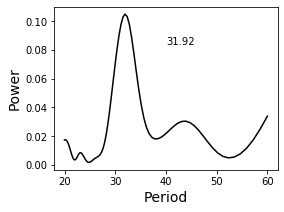

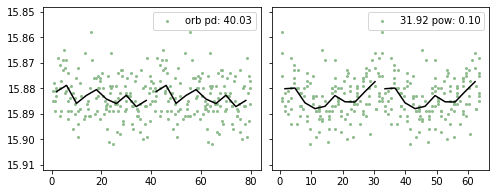

In [15]:
#search and fold with densest region (max space up to 50 days)
#peak goes up to 41.32 if maxspace=100
df,pks = o.multiphase(iband,orb=orb,dense=True,maxspace=50,minp=20,maxp=60,plotpd=True)

In [16]:
dense,mdense = o.finddense(iband,maxspace=50,retall=True)

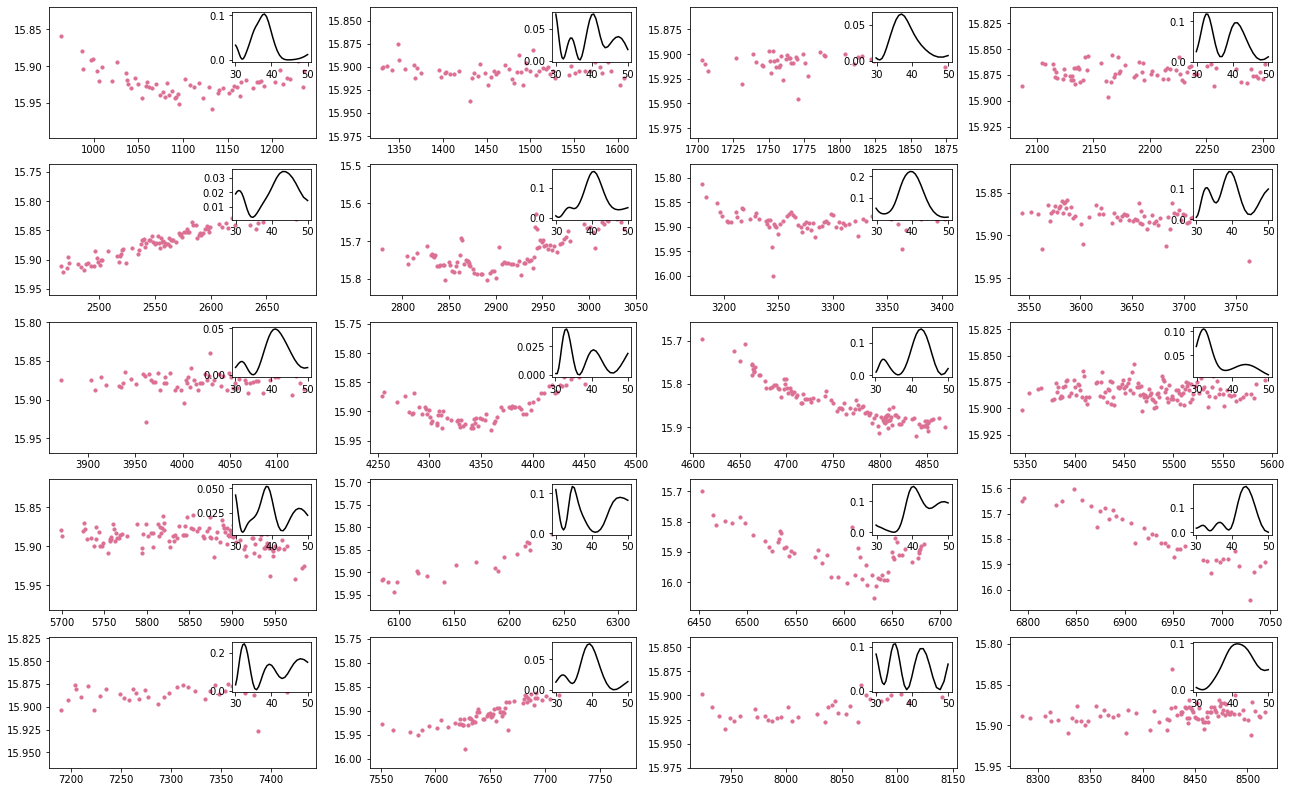

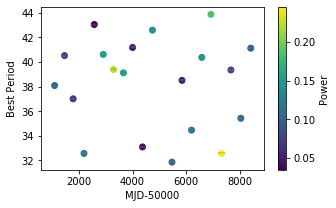

In [17]:
bps,maxpows,stdate,endate = o.denselcpd(iband,dense,minp=30,maxp=50,plotbest=True,onlybp=True)

In [18]:
bps #lots of scatter

[38.08254149532866,
 40.51713920588715,
 37.000477645783036,
 32.557495273308724,
 43.0467016890396,
 40.61402662387664,
 39.3866217376421,
 39.11726631087382,
 41.17741927515088,
 33.08551879941689,
 42.5898900675611,
 31.847376423356955,
 38.502314457046424,
 34.4547379642441,
 40.37146564587086,
 43.87295663103644,
 32.55445365608058,
 39.34651411016918,
 35.41797810350631,
 41.12284915068216]

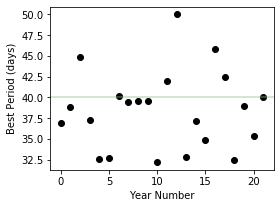

In [19]:
reload(o)
#best period by year
years,bps = o.yrpd(iband,minp=30,maxp=50,orb=orb,plotpd=False) #some clustering at and below established period

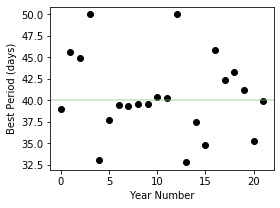

In [20]:
#best period by year, detrended
years,bps = o.yrpd(iband,minp=30,maxp=50,orb=orb,plotpd=False,det=True,window=71)

#### Rolling Periodogram

In [21]:
reload(o)
o.detrend(iband,window=51)
ps,pows,bps,sts = o.rollpd(iband,npoint=100,nroll=20,det=False,minp=20,maxp=60,plot=False)
dps,dpows,dbps,dsts = o.rollpd(iband,npoint=100,nroll=20,det=True,minp=20,maxp=60,plot=False)

Text(0, 0.5, 'LS Best Period')

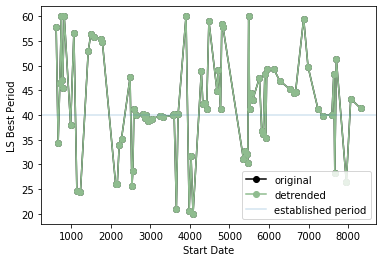

In [22]:
plt.plot(sts,bps,color='black',marker='o',label='original')
plt.plot(sts,bps,color='darkseagreen',marker='o',label='detrended')

plt.axhline(orb,alpha=0.2,label='established period')
plt.legend()
plt.xlabel('Start Date')
plt.ylabel('LS Best Period')

# 3: Look for Orbital Period with LC


In [23]:
orb

40.03

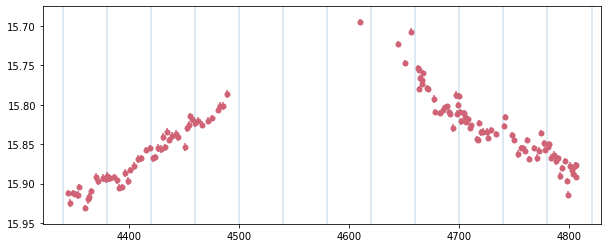

In [24]:
#identify reliable flare center to use for cen

def checkorb(st,end,cen=4700,orb=orb,plcen=False,figsize=(10,4)):
    stday = idays[st:st+1]
    enday = idays[end-1:end]
    fig = plt.figure(figsize=figsize)
    plt.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    plt.ylim(maxi+.02,mini-.02)

    fline = int((stday - cen)/orb)
    lline = int((enday - cen)/orb)
    for i in range(fline-1,lline+2):
        plt.axvline(cen+orb*i,alpha=0.2)
    if plcen: plt.axvline(cen,alpha=0.6)
checkorb(870,1000,plcen=False)

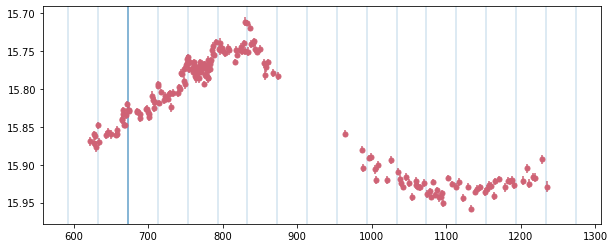

In [25]:
checkorb(0,200,cen=673,plcen=True) #predicts flares on left pretty well

hard to tell in many plots above b/c of other modulations, sampling

In [26]:
def orbsub(inds,cen=673,cenerr=0.4,pd=orb,pderr=0.5,span=True,plcen=False,figsize=(22,30)):
    '''Separate full LC into subplots to better see orbital period timescale
    st,end are lists or arrays of start and end indices of each subplot
    cen: center of flare from which vertical lines are spaced (identify manually)
    add table/columns as arguments if moving to ogle.py'''
    sts = inds[:-1]
    ends = inds[1:]
    
    fig = plt.figure(figsize=figsize)
    rows = int(len(sts)/2)
    if len(sts)%2 == 1: rows+=1
    
    for i in range(len(sts)):
        st,end = sts[i],ends[i]
        #start at 1 for adding subplot
        ax = fig.add_subplot(rows,2,i+1)    
        tot = idays[end-1:end] - idays[st:st+1]
        stday = idays[st:st+1]
        enday = idays[end-1:end] 
    
        ax.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
        maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
        ax.set_ylim(maxi+.02,mini-.02)
        if plcen: ax.axvline(cen)
        fline = int((stday - cen)/pd)
        lline = int((enday - cen)/pd)
        for i in range(fline-1,lline+1):
            #propogate error of ~3 days and 1 day on period
            if span and i<4: ax.axvspan(cen-cenerr+(pd-pderr)*i,cen+cenerr+(pd+pderr)*i,color='darkseagreen',alpha=0.4)
            ax.axvline(cen+pd*i,color='darkseagreen',alpha=0.6)

    return

In [27]:
len(iband)

1724

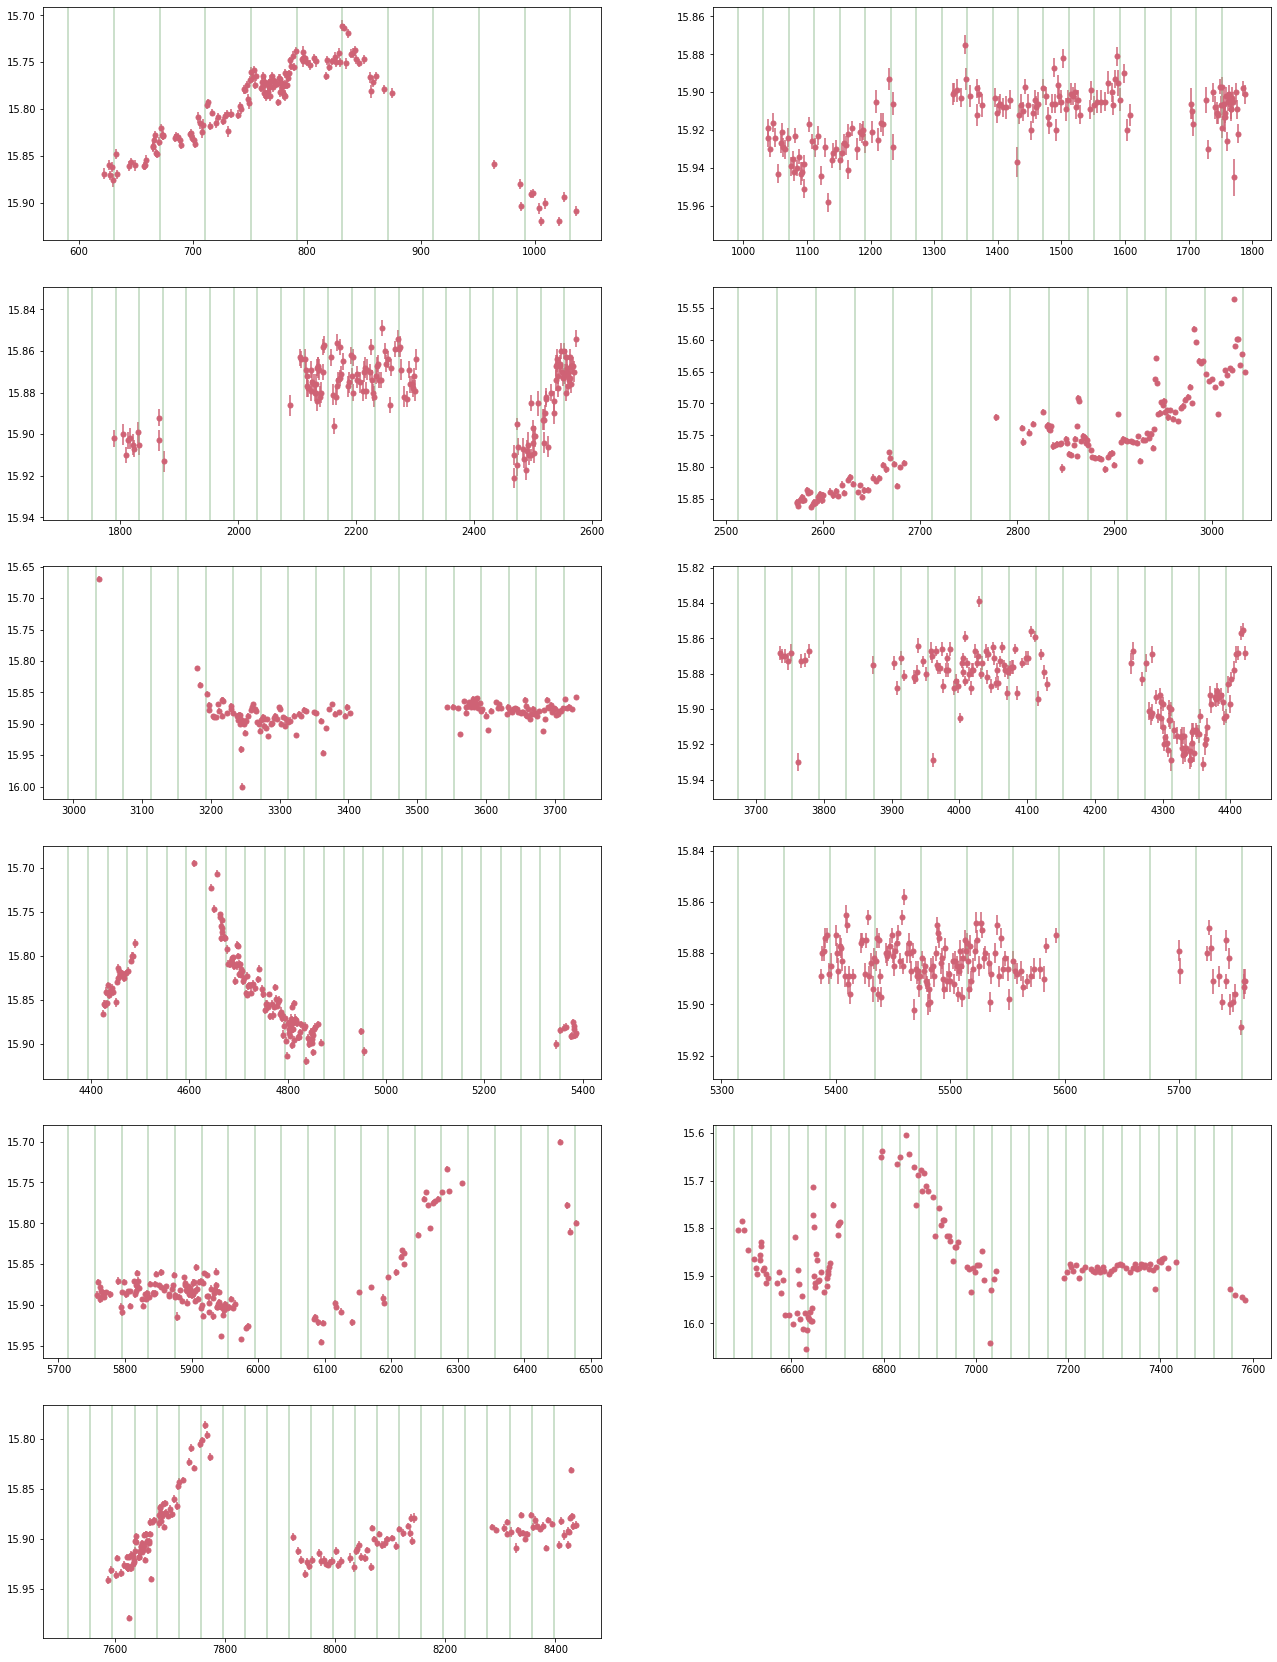

In [28]:
#list of inds to use -- easy to manipulate
#can also use finddense to not have large gaps, but then harder to control number of plots
inds = np.arange(0,len(iband),150)
inds = list(inds)
orbsub(inds,span=False,cen=671)

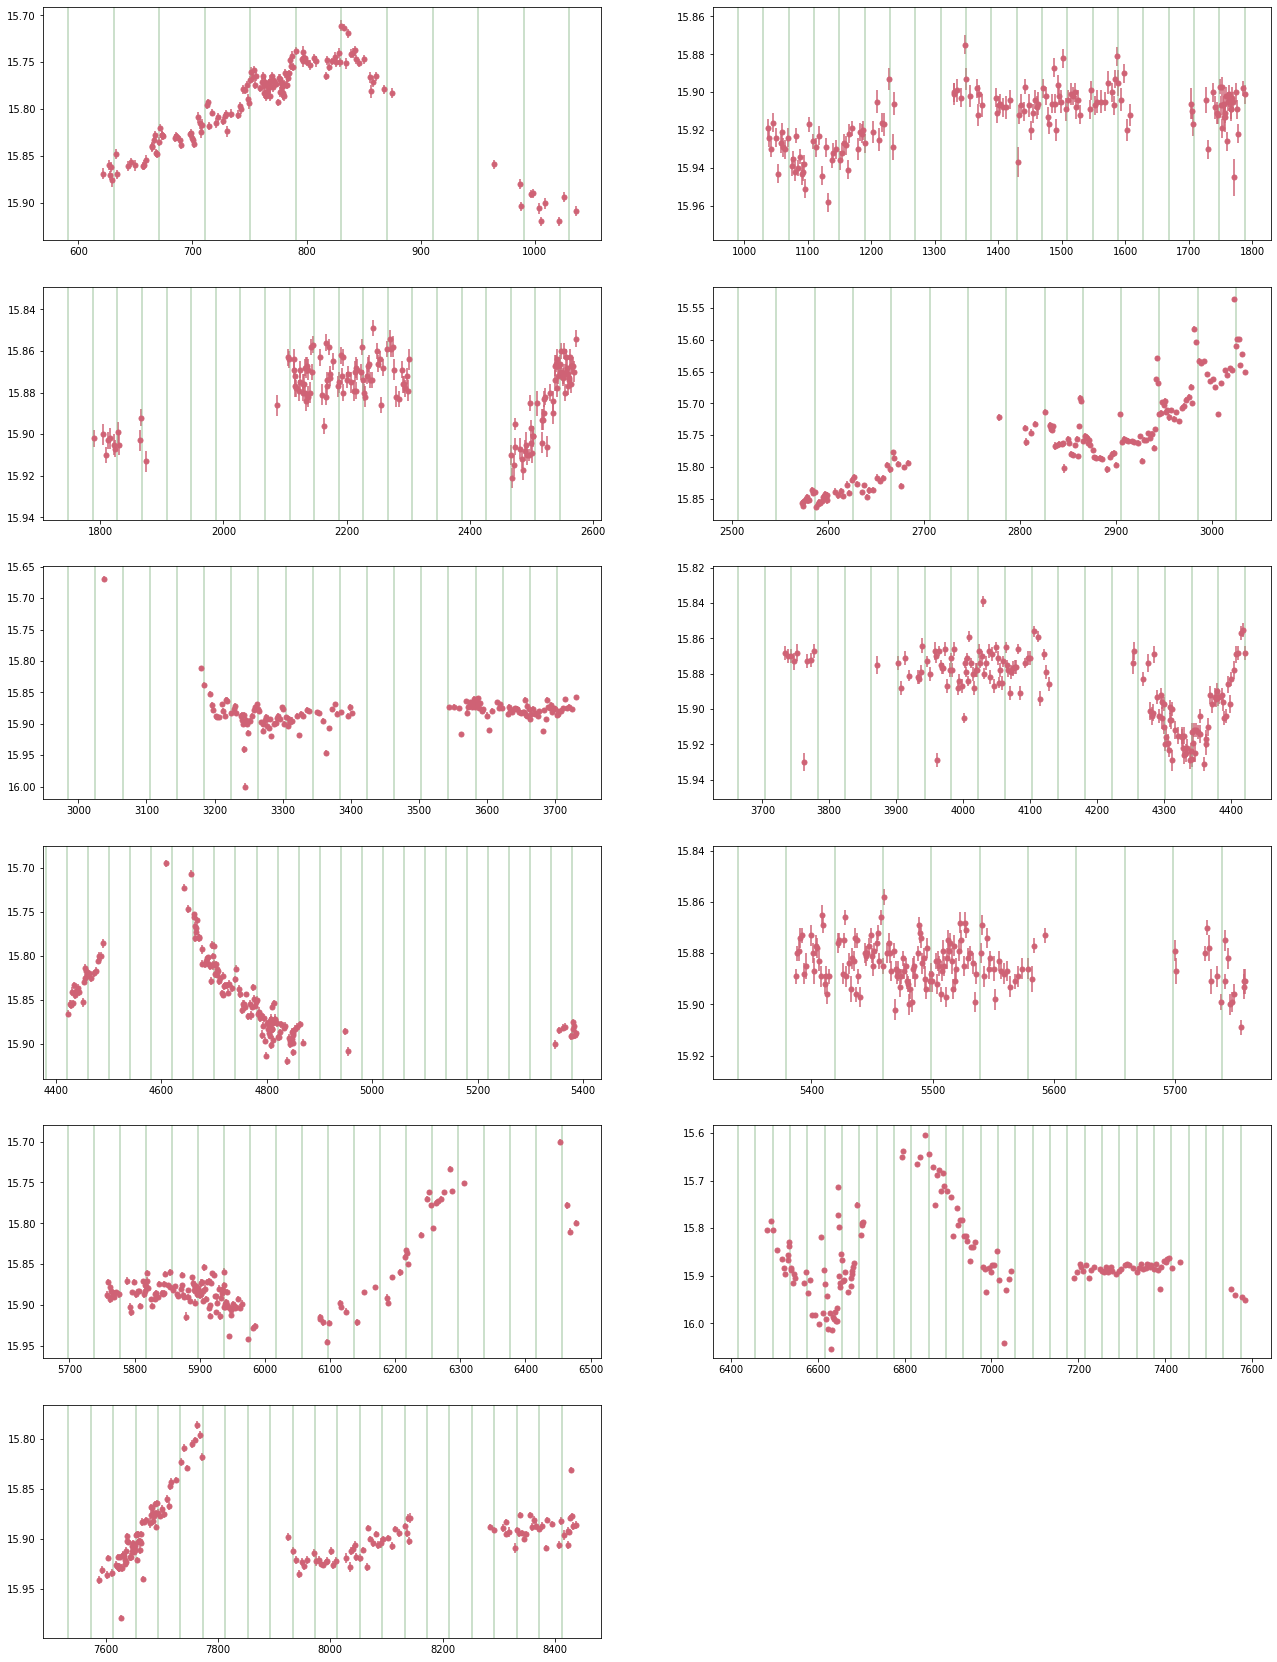

In [29]:
orbsub(inds,span=False,cen=671,pd=39.9)

#### from inspection, 39.9 -- which came up more often in periodograms in the previous section -- seems more effective
- also in phase folds below

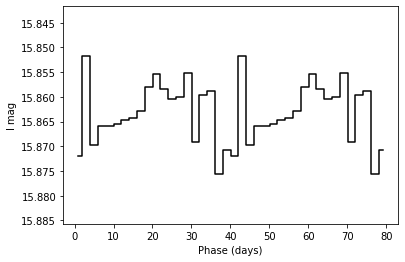

In [30]:
o.phasestep(iband,orb,20,err=False,label='40.03 days')

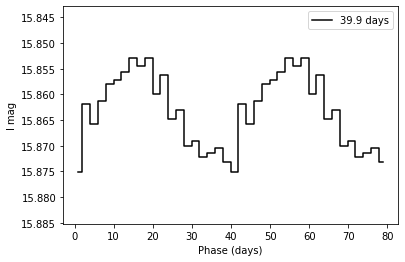

In [31]:
o.phasestep(iband,39.9,20,err=False,label='39.9 days',epoch=-15)
# o.phasestep(iband,39.8,20,err=False,label='39.8 days',epoch=-15)

plt.legend()

be mindful of how the shape can look artificially sinusoidal (from detrending?)

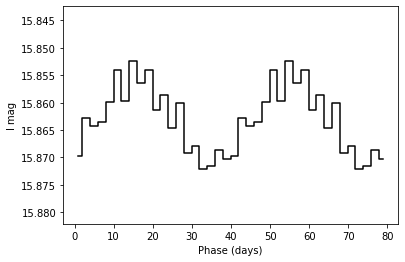

In [32]:
#using detrended
o.detrend(iband,window=81)
o.phasestep(iband,39.9,20,err=False,label='39.9 days',epoch=-15,det=True)
# o.phasestep(iband,orb,20,err=False,label='39.9 days',epoch=-15,det=True)


look into possibility of beat period, especially if 40.03 days derived from X-ray rather than optical methods


# 4: Look for Super-Orbital Period with Periodograms

<Quantity 547.47718062>

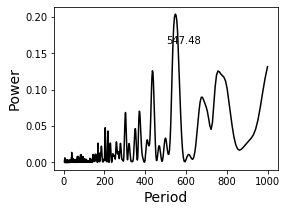

In [33]:
o.periodogram(iband,maxp=1000)

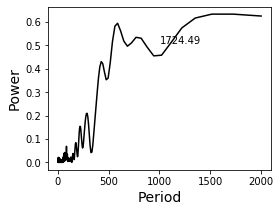

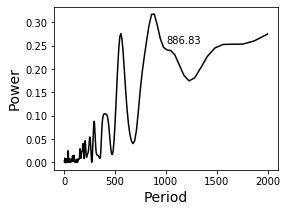

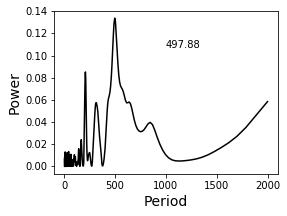

In [34]:
#each OGLE epoch
for i in ilist:
    o.periodogram(i,maxp=2000)

start ind: 0, end ind: -1


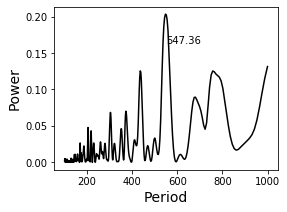

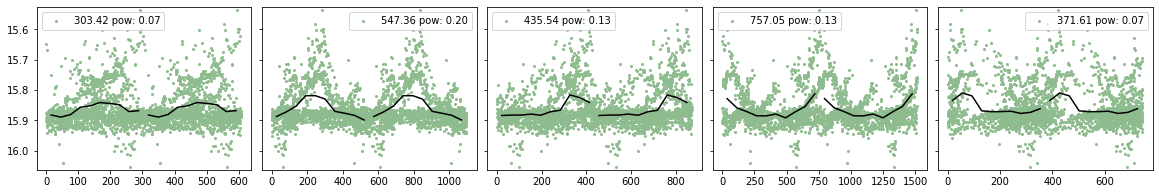

In [35]:
#full LC
df,pks = o.multiphase(iband,orb=orb,incl_orb=False,dense=False,minp=100,maxp=1000,plotpd=True)

# 5: Look for Super-Orbital Period with LC

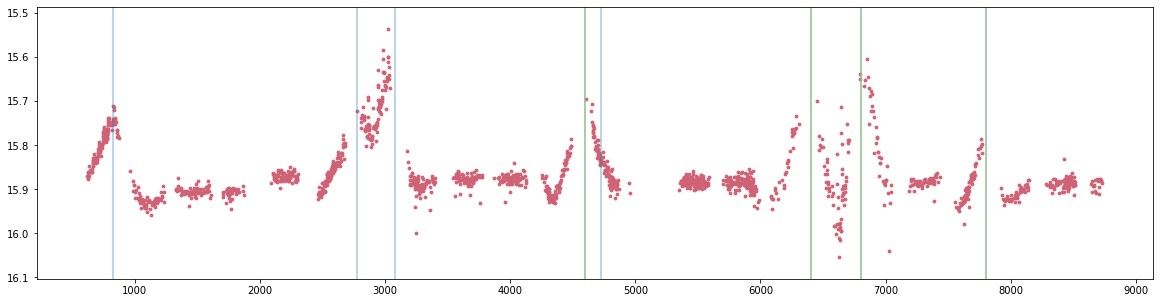

In [36]:
plt.figure(figsize=(20,5))
plt.scatter(idays,imag,color=pink,s=8)

maxi,mini = np.max(imag),np.min(imag)
plt.ylim(maxi+.05,mini-.05)
plt.axvline(830,alpha=0.4)
plt.axvline(830+1950,alpha=0.4)
plt.axvline(830+1950+300,alpha=0.4)
plt.axvline(830+1950+1950,alpha=0.4)
plt.axvline(4600,color='darkseagreen')
plt.axvline(4600+1800,color='darkseagreen')
plt.axvline(4600+1800+400,color='darkseagreen')
plt.axvline(4600+1800+400+1000,color='darkseagreen')

#all the spacings are a bit different -- no region with constant periodicity or enough for linearly increasing etc. to be shown

#### all the spacings are a bit different -- no region with constant periodicity or enough for linearly increasing etc. to be shown

# Add to Summary Table

In [37]:
summ = pd.read_csv('summtab.csv')

In [38]:
num

10

In [39]:
#automatic additions
o.addtotable(iband,vband,summ,num,interp)

In [40]:
#grab row for source
row = summ[summ['src_n']==10]
row

,src_n,ra_deg,dec_deg,spin period,perr,est. period,sep,name,mean I,stdev I,...,redder when brighter,I V-I corr,V V-I corr,I V-I slope,I V-I int,V V-I slope,V V-I int,V-I transition,Type II amp,note
9,10,14.493333,-72.37486,7.92,1.5,40.03,1.21453,SXP 7.92,15.863079,0.06068,...,check,-0.683262,0.773772,-0.433772,15.82257,0.566228,15.82257,yes,NaN,NaN


In [41]:
summ.columns

Index(['src_n', 'ra_deg', 'dec_deg', 'spin period', 'perr', 'est. period',
       'sep', 'name', 'mean I', 'stdev I', 'max I', 'min I', 'I range',
       'mean V', 'stdev V', 'max V', 'min V', 'V range', 'est. period method',
       'best period', 'best superorbital', 'other period', 'period shape',
       'big dip', 'orbital cont', 'superorbital cont', 'mult superorbital',
       'changing superorbital amp', 'redder when brighter', 'I V-I corr',
       'V V-I corr', 'I V-I slope', 'I V-I int', 'V V-I slope', 'V V-I int',
       'V-I transition', 'Type II amp', 'note'],
      dtype='object')

In [42]:
#name SXP 7.92
row['name'] = 'SXP 7.92' 
#best period
row['best period'] = 39.9
# row['period shape'] = 'FRED' #took this out b/c up for debate
#superorbital not continuous
row['superorbital cont'] = 'no'
#superorbital changing amplitude
row['changing superorbital amp'] = 'yes'
row['big dip'] = 0
#V-I
row['V-I transition'] = 'yes'

#put row back into table
summ[summ['src_n']==num] = row

In [43]:
#write out table
# summ.to_csv('summtab.csv',index=False)